# 논문 : 합성데이터를 활용한 유방암 수술 후 치료 유형별 생존 분석: 조직학적 아형을 고려한 인과기반 Uplift 모델링 접근

# 1. 데이터 읽기

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')

import missingno as msno

from sklearn.model_selection import train_test_split

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_plot
from causalml.metrics import plot_gain, plot_qini
from causalml.metrics import auuc_score, qini_score

from IPython.display import Image

In [10]:
# 성능이 주 목적인 머신러닝 구축환경이 아니기에 train과 test를 하나의 데이터로 합침

synbreast_trainset = pd.read_excel('Adjusted_synbreast_trainset.xlsx')
synbreast_testset = pd.read_excel('Adjusted_synbreast_test.xlsx')

df = pd.concat([synbreast_trainset,synbreast_testset], axis=0)
df

,No,AGE,inductal carcinoma,infiltrating duct carcinoma,adenocarcinoma,lobular carcinoma,Metaplastic carcinoma,T1,T1mi,T1a,...,PR,AR,BCS,Mestectomy,pan hysterosalpingo oophorectomy,Chemotherapy,Hormone therapy,Radiation Therapy,Death,Survival period
0,0,33,0,1,0,0,1,1,0,0,...,2,9,1,99,0,1,0,1,0,472
1,1,72,0,1,1,1,0,0,0,1,...,1,99,1,0,0,0,1,1,0,835
2,2,41,0,0,0,0,0,0,0,1,...,99,9,99,1,0,1,1,0,1,1136
3,3,61,1,0,0,1,0,1,0,0,...,1,99,99,0,0,0,1,1,1,145
4,4,44,0,1,0,0,0,0,1,0,...,2,99,0,99,0,0,1,1,1,906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,56,0,1,0,1,1,0,1,0,...,1,99,1,0,0,1,1,1,0,145
4996,4996,65,0,0,1,0,1,0,1,0,...,1,2,1,0,0,1,1,1,1,1360
4997,4997,44,0,1,0,0,1,1,0,0,...,1,9,1,0,1,1,0,1,0,67
4998,4998,58,0,1,0,1,1,0,0,0,...,2,9,1,99,1,0,1,0,0,133


# 2. 변수 선정
- 주제와 연관된 변수만 추출
- 공변량 : 조직학적진단명 5개 변수
- 처치 : 치료여부 3개 변수
- 결과 : 사망여부 변수
- (조건이 되는 수술 후이니깐 BCS, Mestectomy 2개 변수)

In [11]:
a = {
  'AGE': '진단시연령',  # 진단 당시 연령 (예: 45세)
  'inductal carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '관상피암'으로, 유방의 관에서 시작되는 암)
  'infiltrating duct carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '침윤성 관암'으로, 유방의 관에서 시작되어 주변 조직으로 침윤하는 암)
  'adenocarcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '선암'으로, 유방의 샘 조직에서 발생하는 암)
  'lobular carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '소엽암'으로, 유방의 소엽에서 시작되는 암)
  'Metaplastic carcinoma': '조직학적진단명 코드 설명',  # (예: 0=아니오, 1=예, '화생암'으로, 유방암 세포가 다른 조직 형태로 변형된 암)
  'TX': '병기STAGE', # 존재 안함
  'T0': '병기STAGE', # 존재 안함
  'T1': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 종양 크기 및 침습 정도에 따라 T1 단계로 분류)
  'T1mi': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 미세 침습성 암으로 T1의 하위 분류)
  'T1a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T1 중 0.1~0.5cm 크기의 종양)
  'T1b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T1 중 0.5~1cm 크기의 종양)
  'T1c': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 이미지에서 T1c는 0=아니오, 1=예로 나타남, T1 중 1~2cm 크기의 종양)
  'T2': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 2~5cm 크기의 종양)
  'T2a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T2 중 2~3cm 크기의 종양)
  'T2b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, T2 중 3~5cm 크기의 종양)
  'T3': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 5cm 이상의 종양 또는 인접 구조 침범)
  'T4': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 종양이 피부나 흉벽으로 침범된 경우)
  'Nx': '병기STAGE', # 존재 안함
  'N1mi': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 림프절 미세 전이)
  'N1': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 1~3개 림프절 전이)
  'N1a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N1 중 이동성 림프절 전이)
  'N1b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N1 중 내부 유방 림프절 전이)
  'N1c': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N1 중 피부나 근육 내 전이)
  'N2': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 4~9개 림프절 전이)
  'N2a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N2 중 이동성 림프절 4~9개 전이)
  'N2b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N2 중 흉곽 내 또는 상완 림프절 전이)
  'N3': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 10개 이상 림프절 전이)
  'N3a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N3 중 10개 이상 흉곽 아래 림프절 전이)
  'N3b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N3 중 흉곽 내 또는 유방 위 림프절 전이)
  'N3c': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, N3 중 쇄골 위 림프절 전이)
  'M1': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, 원격 전이 존재)
  'M1a': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, M1 중 단일 원격 전이)
  'M1b': '병기STAGE',  # 병기 스테이지 (예: 0=아니오, 1=예, M1 중 다발성 원격 전이)
  'Type of Drink': '음주종류',  # 음주 종류 (예: 0=맥주,1=소주, 2=양주, 99=기타)
  'Smoke': '흡연여부',  # 흡연 여부 (예: 0=비흡연, 1=흡연, 2=과거 흡연)
  'Age of Menarch': '초경연령',  # 초경 연령 (예: 16, 99=모름)
  'Age of Menopause': '폐경연령',  # 폐경 연령 (예: 55, 99=모름)
  'Marriage': '결혼여부',  # 결혼 여부 (예: 0=아니오, 1=예, 99=모름)
  'Age at first birth': '첫출산연령',  # 첫 출산 연령 (예: 20, 99=해당사항 없음)
  'Number of births': '출산자녀수',  # 출산 자녀 수 (예: 3, 99=해당사항 없음)
  'COCP': '경구피임약사용여부',  # 경구 피임약 사용 여부 (예: 0=아니오, 1=예, 99=모름)
  'HRT': 'HRT 사용여부',  # 호르몬 대체 요법(HRT) 사용 여부 (예: 0=아니오, 1=예, 99=모름)
  'Height': '신장값',  # 신장 값 (예: 158cm)
  'Weight': '체중측정값',  # 체중 값 (예: 58kg)
  'BRCA1 PVs': 'BRCA1 병원변형체 검출 여부',  # BRCA1 병원변형체 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BRCA1 VUS': 'BRCA1 미확인변이 검출 여부',  # BRCA1 미확인변이 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BRCA2 PVs': 'BRCA2 병원변형체 검출 여부',  # BRCA2 병원변형체 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BRCA2 VUS': 'BRCA2 미확인변이 검출 여부',  # BRCA2 미확인변이 검출 여부 (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'ER': '면역병리ER검사결과코드',  # Estrogen Receptor (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'PR': '면역병리PR검사결과코드',  # Progesterone Receptor (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'AR': '면역병리AR검사결과코드',  # Androgen Receptor (예: 1=검출됨, 2=미검출, 99=해당사항 없음)
  'BCS': '유방보전적절제술여부 BCS',  # 유방보전적절제술 여부 (예: 0=아니오, 1=예, 99=해당사항 없음)
  'Mestectomy': '유방전절제술여부',  # 유방 전절제술 여부 (예: 0=아니오, 1=예, 99=해당사항 없음)
  'pan hysterosalpingo oophorectomy': '양측난관난소절제술여부',  # 양측 난관 난소 절제술 여부 (예: 0=아니오, 1=예)
  'Chemotherapy': '항암치료여부',  # 항암치료 여부 (예: 0=아니오, 1=예)
  'Hormone therapy': '호르몬치료여부',  # 호르몬치료 여부 (예: 0=아니오, 1=예)
  'Radiation Therapy': '방사선치료여부',  # 방사선치료 여부 (예: 0=아니오, 1=예)
  'Death': '사망여부',  # 사망 여부 (예: 0=아니오, 1=예)
  'Survival period': '암진단후생존일수',  # 암 진단 후 생존 일수 (예: 267일)
}
len(a)

60

In [12]:
df = df[['inductal carcinoma', 'infiltrating duct carcinoma','adenocarcinoma', 'lobular carcinoma', 'Metaplastic carcinoma','BCS','Mestectomy', 'Chemotherapy', 'Hormone therapy', 'Radiation Therapy', 'Death', 'AGE']]
df[['BCS','Mestectomy']] = df[['BCS','Mestectomy']].replace([99,0], np.nan)
df = df.dropna(axis=0, how='all', subset=['BCS','Mestectomy'])
df = df.drop(columns=['BCS','Mestectomy'])
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,inductal carcinoma,infiltrating duct carcinoma,adenocarcinoma,lobular carcinoma,Metaplastic carcinoma,Chemotherapy,Hormone therapy,Radiation Therapy,Death,AGE
0,0,1,0,0,1,1,0,1,0,33
1,0,1,1,1,0,0,1,1,0,72
2,0,0,0,0,0,1,1,0,1,41
5,1,1,0,0,0,0,1,1,0,48
6,0,1,0,0,0,1,0,1,1,71
...,...,...,...,...,...,...,...,...,...,...
4995,0,1,0,1,1,1,1,1,0,56
4996,0,0,1,0,1,1,1,1,1,65
4997,0,1,0,0,1,1,0,1,0,44
4998,0,1,0,1,1,0,1,0,0,58


In [13]:
import scipy.stats as stats

for i in list(df.iloc[:,:8].columns):
    a = df[[i, 'Death']]
    data = pd.crosstab(a[i], a.Death)
    # 카이제곱 독립성 검정
    chi2, p, dof, expected = stats.chi2_contingency(data)
    
    #print("Chi-square 값:", chi2)
    print(f'{i} & Death')
    print(f"p-value: {p} \n")
    #print("자유도:", dof)
    #print("기대도수표:\n", pd.DataFrame(expected))


inductal carcinoma & Death
p-value: 0.1844965823738165 

infiltrating duct carcinoma & Death
p-value: 0.9943410683166792 

adenocarcinoma & Death
p-value: 0.46786808791708023 

lobular carcinoma & Death
p-value: 0.4987503252525831 

Metaplastic carcinoma & Death
p-value: 0.31805072671803375 

Chemotherapy & Death
p-value: 0.5389599741545599 

Hormone therapy & Death
p-value: 0.744131622873396 

Radiation Therapy & Death
p-value: 0.2559845448460345 



In [14]:
df.Death.value_counts()

Death
0    5809
1    3106
Name: count, dtype: int64

<Axes: >

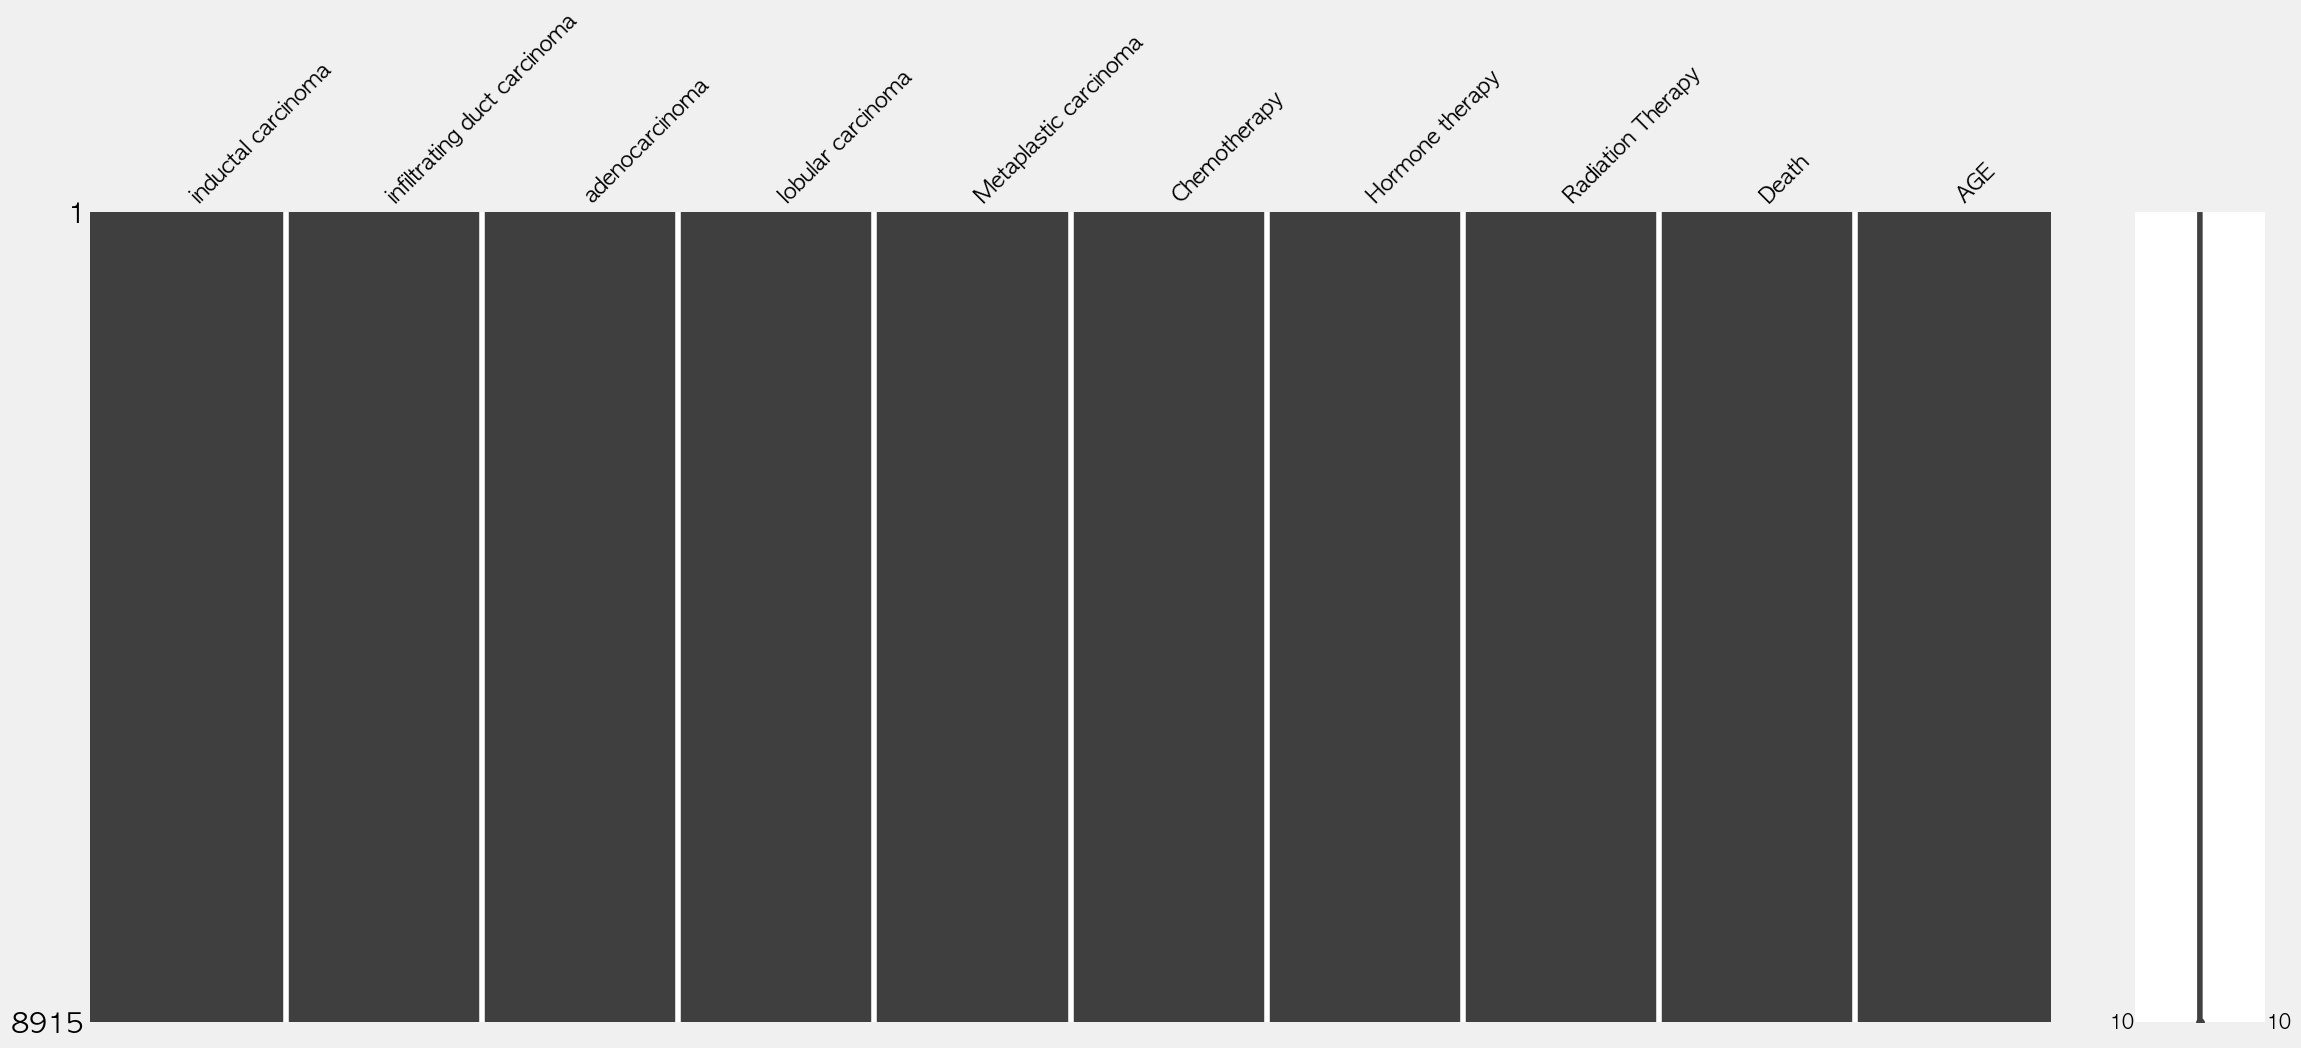

In [15]:
msno.matrix(df)

# 3. 데이터 분석

In [16]:
df.columns

Index(['inductal carcinoma', 'infiltrating duct carcinoma', 'adenocarcinoma',
       'lobular carcinoma', 'Metaplastic carcinoma', 'Chemotherapy',
       'Hormone therapy', 'Radiation Therapy', 'Death', 'AGE'],
      dtype='object')

In [17]:
synbreast = df.copy()

treatment_mapping = {
    (0,0,0): 'c',   # 무처치
    (1,0,0): 't1',   # 항암 단독
    (0,1,0): 't2',   # 호르몬 단독
    (0,0,1): 't3',   # 방사선 단독  
    (1,1,0): 't4',   # 항암+호르몬
    (1,0,1): 't5',   # 항암+방사선
    (0,1,1): 't6',   # 호르몬+방사선
    (1,1,1): 't7'    # 삼중요법
}

synbreast['combo_tx'] = synbreast[['Chemotherapy','Hormone therapy','Radiation Therapy']]\
                  .apply(tuple, axis=1).map(treatment_mapping)
synbreast = synbreast.drop(columns=['Chemotherapy','Hormone therapy', 'Radiation Therapy'])
synbreast

,inductal carcinoma,infiltrating duct carcinoma,adenocarcinoma,lobular carcinoma,Metaplastic carcinoma,Death,AGE,combo_tx
0,0,1,0,0,1,0,33,t5
1,0,1,1,1,0,0,72,t6
2,0,0,0,0,0,1,41,t4
5,1,1,0,0,0,0,48,t6
6,0,1,0,0,0,1,71,t5
...,...,...,...,...,...,...,...,...
4995,0,1,0,1,1,0,56,t7
4996,0,0,1,0,1,1,65,t7
4997,0,1,0,0,1,0,44,t5
4998,0,1,0,1,1,0,58,t2


In [18]:
for i in ['inductal carcinoma', 'infiltrating duct carcinoma', 'adenocarcinoma',
       'lobular carcinoma', 'Metaplastic carcinoma','Death']:
    synbreast[i] = synbreast[i].astype('category')

In [22]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
synbreast[['AGE']] = ss.fit_transform(synbreast[['AGE']])
synbreast.AGE

0      -1.259475
1       1.200737
2      -0.754816
5      -0.313239
6       1.137655
          ...   
4995    0.191419
4996    0.759161
4997   -0.565569
4998    0.317584
4999   -1.196393
Name: AGE, Length: 8915, dtype: float64

In [23]:
df_train, df_test = train_test_split(synbreast, test_size=0.2, random_state=111)
x_names = ['inductal carcinoma', 'infiltrating duct carcinoma', 'adenocarcinoma','lobular carcinoma', 'Metaplastic carcinoma']

In [31]:
uplift_model = UpliftRandomForestClassifier(control_name='c', max_depth=5, random_state=24)

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['combo_tx'].values,
                 y=df_train['Death'].values,
                )

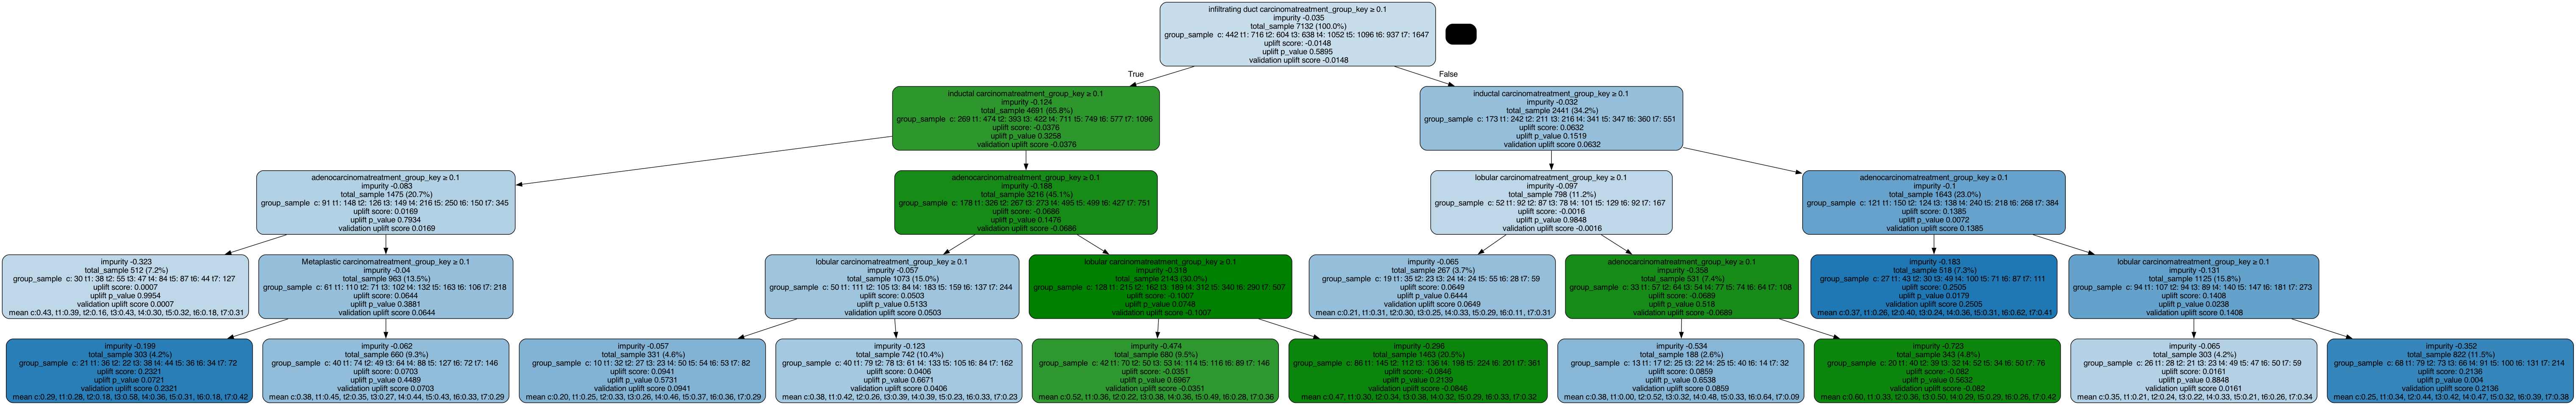

In [32]:
graph = uplift_tree_plot(uplift_model.uplift_forest[0].fitted_uplift_tree, df_train[x_names].columns)
Image(graph.create_png())

In [18]:
import graphviz
graph = uplift_tree_plot(uplift_model.uplift_forest[0].fitted_uplift_tree, df_train[x_names].columns)
output_filename = 'uplift_tree_plot1.png'
graph.write_png(output_filename)

True

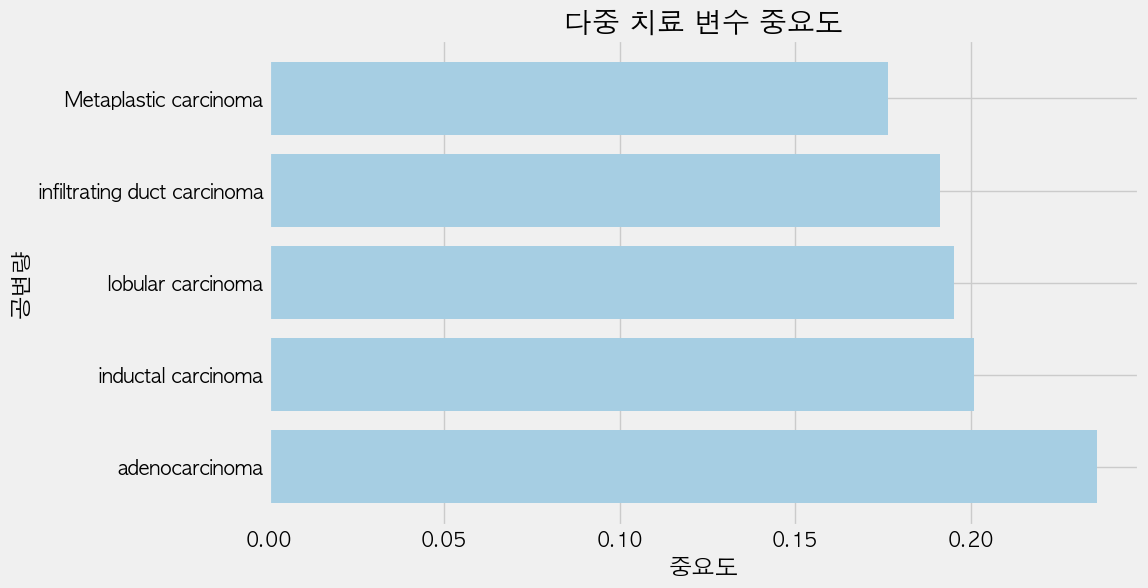

In [33]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')

feature_importances = uplift_model.feature_importances_
feature_names = df_train[x_names].columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['feature'], importance_df_sorted['importance'])
plt.xlabel('중요도')
plt.ylabel('공변량')
plt.title('다중 치료 변수 중요도')
plt.show()

In [34]:
df_res = uplift_model.predict(df_test[x_names].values)
print(df_res.shape)
df_res

(1783, 7)


array([[ 0.05308533, -0.06557237, -0.147947  , ..., -0.05720811,
        -0.11669549, -0.16446985],
       [-0.10566779, -0.03701851,  0.00820204, ..., -0.04732384,
        -0.03988122,  0.05448033],
       [-0.17294177,  0.0115307 , -0.15635683, ..., -0.11121006,
        -0.21385982, -0.10960618],
       ...,
       [-0.02904439, -0.05961708, -0.07373601, ..., -0.05515586,
         0.1627307 ,  0.03382605],
       [ 0.03986424,  0.04080597, -0.00279239, ...,  0.05765919,
         0.04680327,  0.02445154],
       [-0.12131039, -0.08784686, -0.07675306, ..., -0.14951565,
        -0.09904376, -0.1539864 ]])

In [35]:
y_pred = uplift_model.predict(df_test[x_names].values)
y_pred.shape

(1783, 7)

In [36]:
result = pd.DataFrame(y_pred,
                      columns=uplift_model.classes_[1:])
result.head()

,t1,t2,t3,t4,t5,t6,t7
0,0.053085,-0.065572,-0.147947,-0.107159,-0.057208,-0.116695,-0.164470
1,-0.105668,-0.037019,0.008202,0.052892,-0.047324,-0.039881,0.054480
2,-0.172942,0.011531,-0.156357,-0.124321,-0.111210,-0.213860,-0.109606
3,-0.070059,-0.088393,-0.072852,-0.133096,-0.115455,-0.058870,-0.094739
4,0.023761,0.006403,0.003086,0.063458,-0.037479,0.056232,0.026213


In [37]:
best_treatment = np.where((result < 0).all(axis=1),
                           'c',
                           result.idxmax(axis=1))

actual_is_best = np.where(df_test['combo_tx'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['combo_tx'] == 'c', 1, 0)
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

In [41]:
synth

,t1,t2,t3,t4,t5,t6,t7
2,-0.172942,0.011531,-0.156357,-0.124321,-0.111210,-0.213860,-0.109606
8,0.023761,0.006403,0.003086,0.063458,-0.037479,0.056232,0.026213
12,-0.070059,-0.088393,-0.072852,-0.133096,-0.115455,-0.058870,-0.094739
20,-0.070059,-0.088393,-0.072852,-0.133096,-0.115455,-0.058870,-0.094739
21,-0.073748,-0.108168,-0.071034,-0.100637,-0.110998,-0.049804,-0.087097
...,...,...,...,...,...,...,...
1766,-0.059649,0.041618,0.025823,0.125887,0.059657,0.089097,0.033081
1767,0.109391,0.105368,0.145457,0.176669,0.085570,0.099829,0.094377
1768,-0.105668,-0.037019,0.008202,0.052892,-0.047324,-0.039881,0.054480
1769,-0.050448,-0.132605,-0.042986,-0.032338,-0.017076,-0.043966,-0.045296


In [40]:
df_test.AGE

7794    0.380666
1846   -0.817898
1520    0.569914
1113    0.885325
1746    0.254502
          ...   
1320    1.642314
4362   -0.691734
1102    0.128337
4437   -0.944063
48     -1.385640
Name: AGE, Length: 1783, dtype: float64

uplift_tree    0.91066
dtype: float64


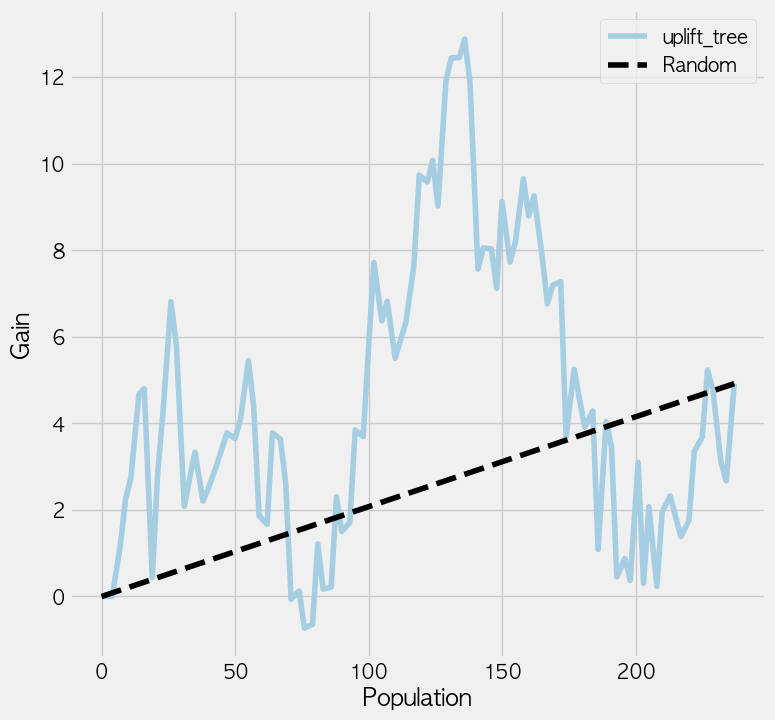

In [38]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             Death = df_test.loc[synthetic, 'Death'].values.astype(int),
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_[1:])))
auuc_metrics['tau'] = 


score = auuc_score(auuc_metrics, outcome_col='Death', treatment_col='is_treated')
print(score)
plot_gain(auuc_metrics, outcome_col='Death', treatment_col='is_treated',treatment_effect_col='')

uplift_tree    0.155301
dtype: float64


Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


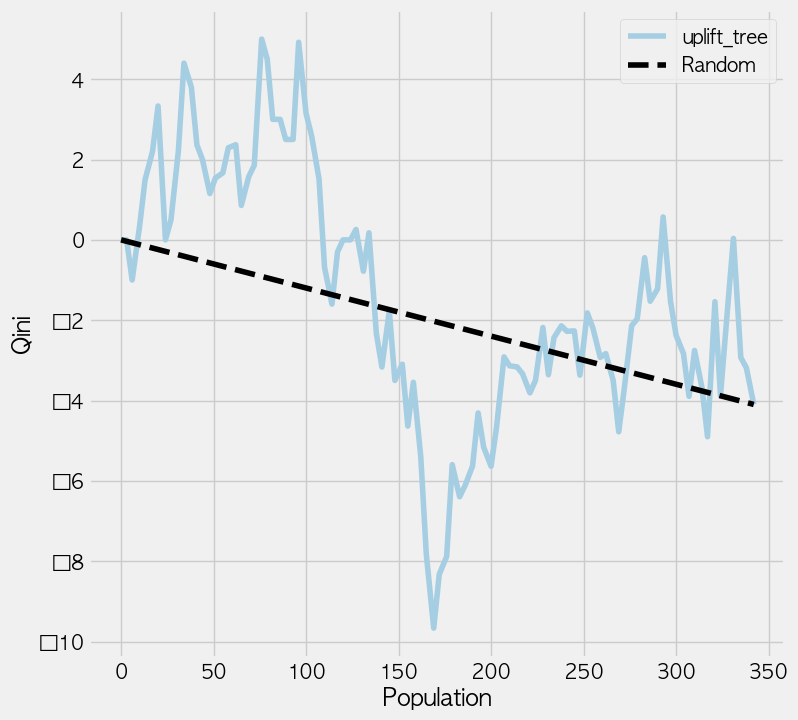

In [25]:
score = qini_score(auuc_metrics, outcome_col='Death', treatment_col='is_treated')
print(score)
plot_qini(auuc_metrics, outcome_col='Death', treatment_col='is_treated')

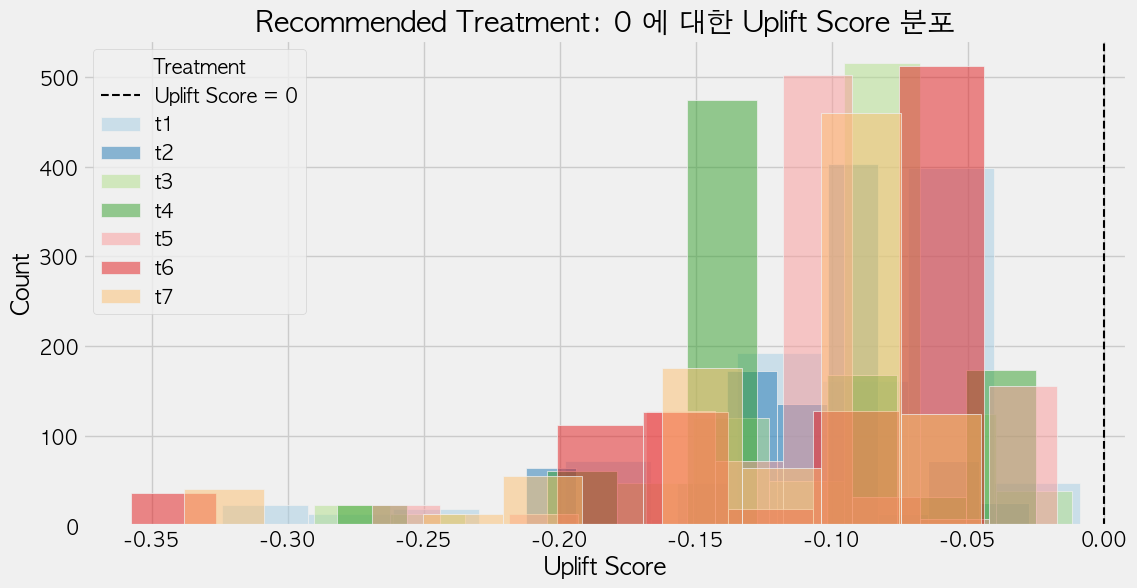

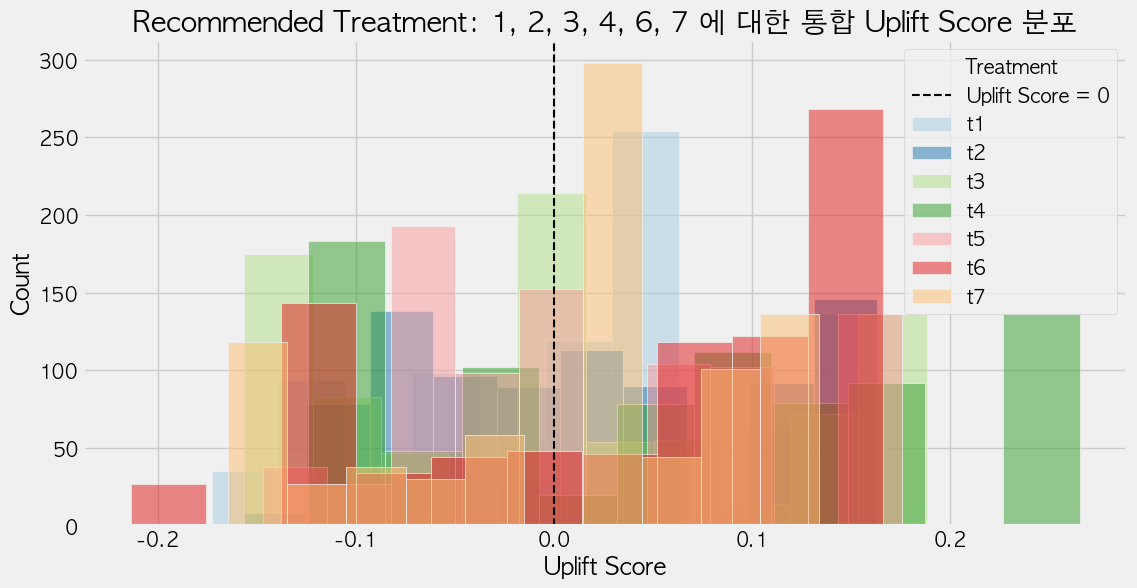

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rcParams['axes.unicode_minus'] = False 


plot_df = df_res[[f'delta_t{i}' for i in range(1, 8)] + ['recommended_treatment']].copy()
plot_df.columns = [f't{i}' for i in range(1, 8)] + ['recommended_treatment']

unique_recommended_treatments = sorted([str(x) for x in plot_df['recommended_treatment'].unique()])

first_recommended_treatment = unique_recommended_treatments[0]
other_recommended_treatments = unique_recommended_treatments[1:]

original_unique_recs = sorted(df_res['recommended_treatment'].unique())
first_original_rec = original_unique_recs[0]
other_original_recs = original_unique_recs[1:]


df_subset_first = plot_df[plot_df['recommended_treatment'] == first_original_rec].drop(columns=['recommended_treatment'])

plt.figure(figsize=(12, 6)) 

for col in df_subset_first.columns:
    sns.histplot(df_subset_first[col], kde=False, bins=10, label=col, alpha=0.5)

plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1.5, label='Uplift Score = 0')

plt.xlabel("Uplift Score")
plt.ylabel("Count")
# 타이틀에는 문자열로 변환된 값 사용
plt.title(f"Recommended Treatment: {str(first_original_rec)} 에 대한 Uplift Score 분포")
plt.legend(title="Treatment")
plt.grid(True)
plt.show()

# --- 나머지 recommended_treatment 값들에 대한 통합 그래프 ---
if other_original_recs: # 남은 recommended_treatment 값이 있을 경우에만 실행
    df_subset_others = plot_df[plot_df['recommended_treatment'].isin(other_original_recs)].drop(columns=['recommended_treatment'])

    plt.figure(figsize=(12, 6)) 

    for col in df_subset_others.columns:
        sns.histplot(df_subset_others[col], kde=False, bins=10, label=col, alpha=0.5)

    plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1.5, label='Uplift Score = 0')

    plt.xlabel("Uplift Score")
    plt.ylabel("Count")
    # 타이틀에 사용할 때는 문자열로 변환된 리스트를 join
    plt.title(f"Recommended Treatment: {', '.join([str(x) for x in other_original_recs])} 에 대한 통합 Uplift Score 분포")
    plt.legend(title="Treatment")
    plt.grid(True)
    plt.show()

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

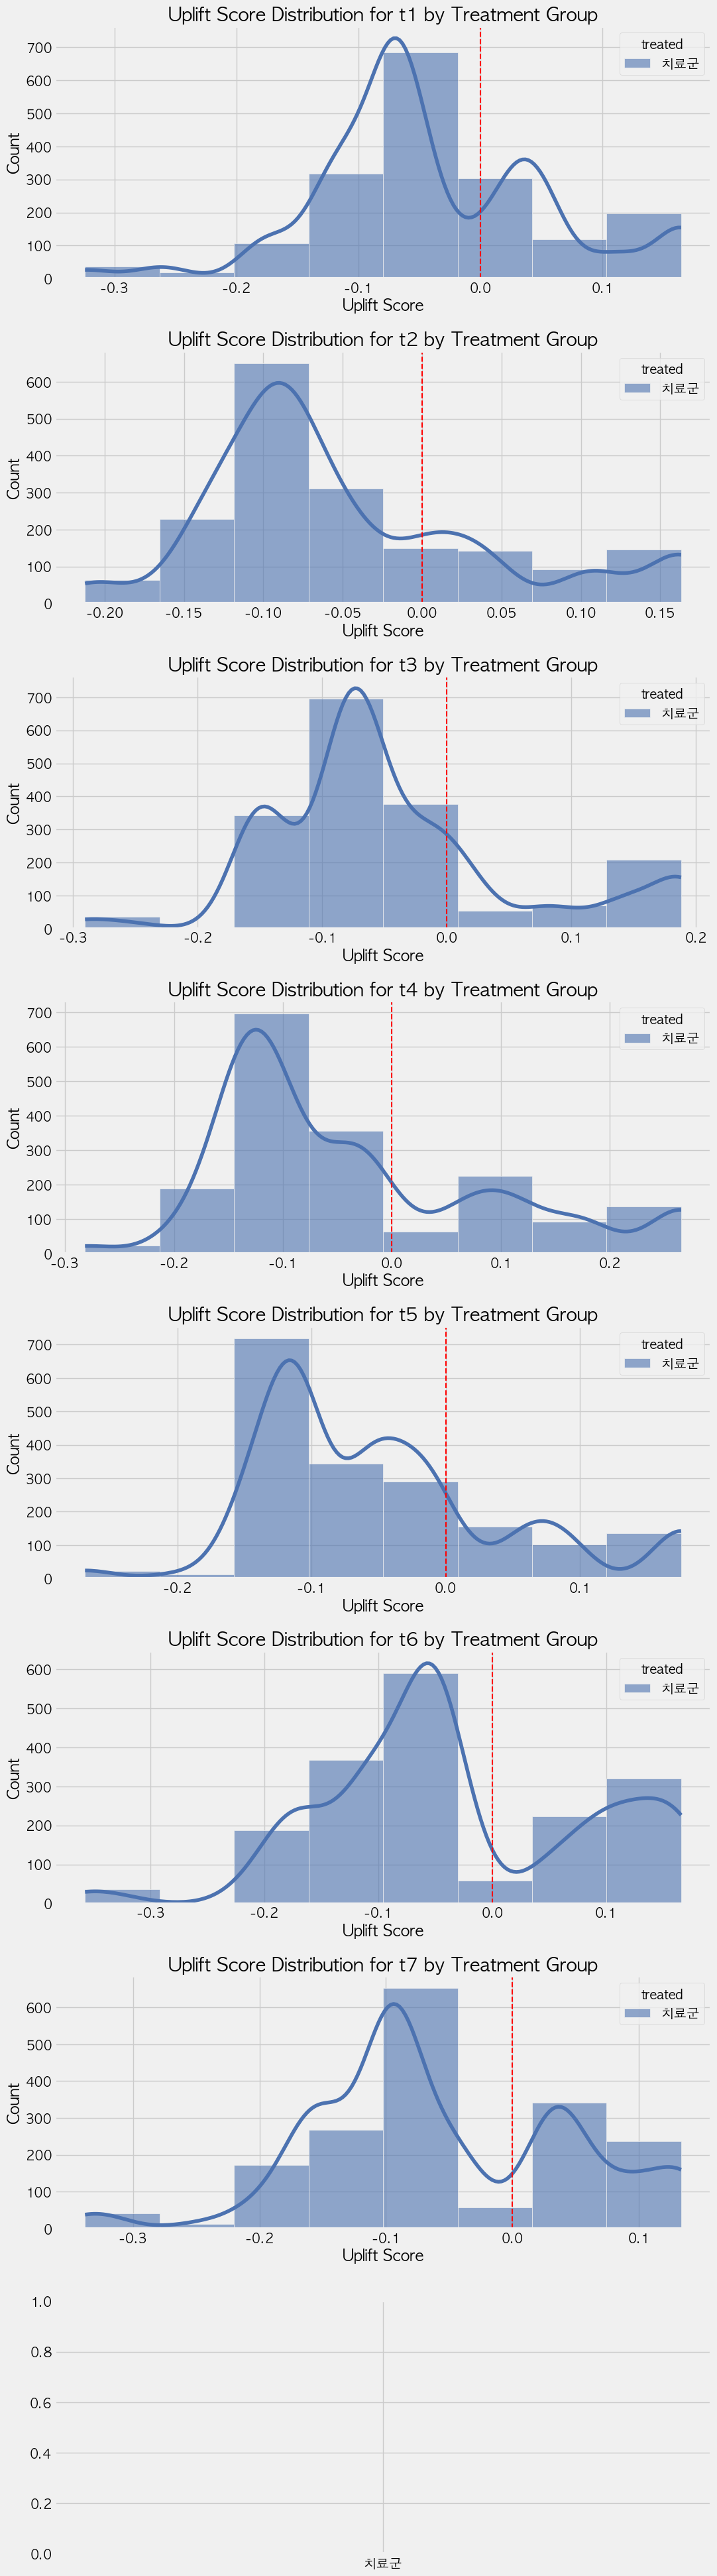

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rcParams['axes.unicode_minus'] = False 

df_res1 = df_res.assign(treated=df_test['combo_tx'].values).copy()

delta_cols = [f'delta_t{i}' for i in range(1, 8)]
plot_df = df_res1[delta_cols + ['treated']].copy()
plot_df.columns = [f't{i}' for i in range(1, 8)] + ['treated']

plot_df['treated'] = plot_df['treated'].apply(
    lambda x: '대조군' if x == 0 else '치료군'
)


uplift_score_cols = [col for col in plot_df.columns if col.startswith('t')]

fig, axes = plt.subplots(nrows=len(uplift_score_cols), ncols=1, figsize=(12, 5 * len(uplift_score_cols)))
fig.tight_layout(pad=4.0) 


for i, treatment_col in enumerate(uplift_score_cols):
    sns.histplot(data=plot_df, x=treatment_col, hue='Treatment_Group', 
                 kde=True, bins=8, ax=axes[i], palette='deep', alpha=0.6) 
    
    axes[i].axvline(x=0.0, color='red', linestyle='--', linewidth=1.5, label='Uplift Score = 0')
     
    axes[i].set_xlabel("Uplift Score")
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"Uplift Score Distribution for {treatment_col} by Treatment Group")

plt.show()